# Experiment analysis

In [ ]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langsmith import Client
from scipy.special import comb
from scipy.stats import bootstrap
from tqdm import tqdm

load_dotenv(".env.secrets")

True

# Plot styling

In [ ]:
color_order = ["blue", "orange", "yellow", "purple", "green"]
color_dict = {
    "blue": {
        "dark": (0.2745098, 0.4, 0.6),
        "medium": (0.39607843, 0.5254902, 0.71764706),
        "light": (0.65098039, 0.79215686, 0.94117647),
    },
    "orange": {
        "dark": (0.71764706, 0.36470588, 0.24313725),
        "medium": (0.88627451, 0.4627451, 0.34901961),
        "light": (1.0, 0.63921569, 0.44705882),
    },
    "yellow": {
        "dark": (0.85882353, 0.58431373, 0.18039216),
        "medium": (0.89803922, 0.68235294, 0.39607843),
        "light": (0.96470588, 0.84705882, 0.52941176),
    },
    "purple": {
        "dark": (0.6627451, 0.16078431, 0.30980392),
        "medium": (0.7372549, 0.39607843, 0.55294118),
        "light": (0.89019608, 0.38823529, 0.52941176),
    },
    "green": {
        "dark": (0.22352941, 0.46666667, 0.4549019607843137),
        "medium": (0.29803922, 0.60784314, 0.58431373),
        "light": (0.50980392, 0.76862745, 0.76470588),
    },
}

colors = [color_dict[k]["medium"] for k in color_order]
colors_light = [color_dict[k]["light"] for k in color_order]
colors_dark = [color_dict[k]["dark"] for k in color_order]

sonnet_colors = color_dict["orange"]
opus_colors = color_dict["blue"]
flash_colors = color_dict["yellow"]
pro_colors = color_dict["purple"]


def get_color(label: str):
    if "flash" in label:
        return flash_colors
    if "pro" in label:
        return pro_colors
    if "opus" in label or "full" in label or "shot" in label:
        return opus_colors
    if "sonnet" in label:
        return sonnet_colors

    return "black"


FIGSIZE = (9, 6)
FONTSIZE = 19
LABELSIZE = 17
TEXTSIZE = 12

PROVER_NAME = "AX Base prover"
PROVER_ACRONYM = "AX-BP"

# Data management

In [ ]:
def get_experiment_names_by_dataset(
    client: Client, dataset_name: str = "putnam_medium_solutions"
) -> list[str]:
    """
    Get all experiment names (project names) for a given dataset.
    """
    dataset_id = get_dataset_id(dataset_name, client)
    # List all experiment names (LangSmith calls experiments "projects")
    experiment_names = [
        exp.name for exp in list(client.list_projects()) if exp.reference_dataset_id == dataset_id
    ]

    return experiment_names


def get_dataset_id(dataset_name: str, client: Client) -> str:
    """Get the dataset ID for a given dataset name."""
    datasets = list(client.list_datasets())
    for dataset in datasets:
        if dataset.name == dataset_name:
            return dataset.id
    raise ValueError(f"Dataset {dataset_name} not found")


def filter_experiment_names_by_config(config_name: str, experiment_names: list[str]) -> list[str]:
    """
    Get all the experiment names that contain the given config name.
    Experiment names follow the format: ax-datetime-datasetname-configname-uid
    """
    filtered_experiments = [name for name in experiment_names if f"-{config_name}-" in name]

    return filtered_experiments


def aggregate_results_by_run(
    results_list: list[pd.DataFrame], target_quantities: list[str], group_by: list[str]
) -> pd.DataFrame:
    """Aggregate results by run."""
    relevant_cols = target_quantities + group_by
    combined = pd.concat(
        [df[relevant_cols] for df in results_list],
        keys=[f"run_{i}" for i in range(len(results_list))],
        names=["run_id", "row_idx"],
    )

    result_matrix = (
        combined.groupby(["run_id"] + group_by)[target_quantities]
        .sum()
        .unstack(level="run_id", fill_value=0)
    )

    return result_matrix  # [samples x runs x quantities]


def compute_pass_at_k(df: pd.DataFrame, k: int):
    """
    df: DataFrame where rows are problems and columns are repetitions (1 for pass, 0 for fail)
    k: The 'k' in pass@k

    pass@k = mean(1 - ((n-c)Ck / nCk))
    """
    n = df.shape[1]
    c = df.sum(axis=1).values
    pass_at_k = 1.0 - (comb(n - c, k) / comb(n, k))
    ci_95 = bootstrap(
        (pass_at_k,), np.mean, confidence_level=0.95, n_resamples=10000
    ).confidence_interval
    return pass_at_k.mean(), ci_95

## Download the relevant experiment data

In [ ]:
from dataclasses import dataclass, field


@dataclass
class Ablation:
    name: str
    dataset_name: str
    config_names: list[str]
    data: dict[str, list[pd.DataFrame]] = field(default_factory=dict)

    def __post_init__(self):
        for config_name in self.config_names:
            self.data[config_name] = []


def fetch_ablation_data(ablation: Ablation, client: Client):
    """Retrieve the data for all the experiments in a given ablation study."""
    experiments_dataset = get_experiment_names_by_dataset(client, ablation.dataset_name)
    for config in tqdm(ablation.config_names):
        experiment_names = filter_experiment_names_by_config(config, experiments_dataset)
        for experiment_name in experiment_names:
            data = client.get_test_results(project_name=experiment_name)
            ablation.data[config].append(data)

    return ablation

# Long run bottom up study

In [ ]:
from scipy import stats


def get_aggregated_cumulative_proven(
    results_list: list[pd.DataFrame], max_iter: int = 100
) -> pd.DataFrame:
    """
    Combine multiple experiment results into a single DataFrame of cumulative proven theorems.
    Every column is an experiment.
    """
    proven_matrix = aggregate_results_by_run(
        results_list, ["feedback.is_proven"], ["feedback.main_theorem_iterations"]
    )

    cumulative_proven = proven_matrix.reindex(range(1, max_iter + 1), fill_value=0).cumsum()
    return cumulative_proven / results_list[0].shape[0]


def get_stats_for_plotting(df_aggregated: pd.DataFrame):
    """
    Computes mean and 95% CI for the aggregated cumulative totals.
    Written by our friend.
    """
    n = df_aggregated.shape[1]  # Number of realizations
    mean_val = df_aggregated.mean(axis=1)
    sem = df_aggregated.sem(axis=1)

    # Use t-distribution for 95% CI (important for small N)
    # df (degrees of freedom) = n - 1
    confidence = 0.95
    t_multiplier = stats.t.ppf((1 + confidence) / 2.0, n - 1)

    ci_bound = t_multiplier * sem

    return mean_val, sem, ci_bound

In [ ]:
CONFIG_NAME_MAP = {
    "singleshot": "Opus pass@k",
    "memoryless": "Feedback",
    "previousk": "History",
    "experience": "Self-reflection",
    "nowebsearch": "No web search",
    "fullsystem": "Full system",
}

pass_at_k_configs = ["singleshot"]
cumulative_proven_configs = [k for k in CONFIG_NAME_MAP.keys() if k not in pass_at_k_configs]

In [ ]:
# client = Client()
# dataset_name = "putnam_medium_solutions"
# long_run = Ablation("long_run", dataset_name, list(CONFIG_NAME_MAP.keys()))
# long_run = fetch_ablation_data(long_run, client)

In [ ]:
import pickle

# with open("data/long_run.pkl", "wb") as f:
#     pickle.dump(long_run, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("data/long_run.pkl", "rb") as f:
    long_run = pickle.load(f)

We are interested in computing the cumulative number of proven theorems as a function of the number of iterations.

In [ ]:
cumulative_proven = {}
for config in cumulative_proven_configs:
    results = long_run.data[config]
    if results:
        cumulative_proven[config] = get_aggregated_cumulative_proven(results)

We can also compute the pass@k for the iterative process.
Let's get the pass@1 to compare with Hilbert for them.

In [ ]:
pass_at_k_by_config = {}

for config in cumulative_proven_configs:
    results = long_run.data[config]
    proven_matrix = aggregate_results_by_run(results, ["feedback.is_proven"], ["input.inputs.path"])
    pass_at_k_by_config[config] = {1: compute_pass_at_k(proven_matrix, 1)}

We can also compute the pass@k of the single shot for multiple $k$.

In [ ]:
k_values = np.arange(1, 41)

for config in pass_at_k_configs:
    results = long_run.data[config]
    proven_matrix = aggregate_results_by_run(results, ["feedback.is_proven"], ["input.inputs.path"])
    pass_at_k_by_config[config] = {k: compute_pass_at_k(proven_matrix, k) for k in k_values}

In [ ]:
import matplotlib.pyplot as plt

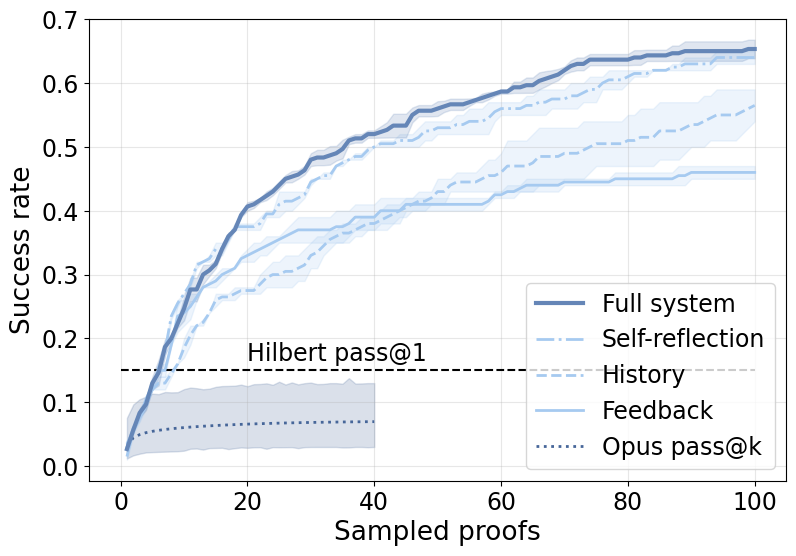

In [ ]:
STYLE_MAP = {
    "singleshot": {"color": opus_colors["dark"], "linestyle": ":"},
    "memoryless": {"color": opus_colors["light"], "linestyle": "-"},
    "previousk": {"color": opus_colors["light"], "linestyle": "--"},
    "experience": {"color": opus_colors["light"], "linestyle": "-."},
    "nowebsearch": {"color": opus_colors["light"], "linestyle": ":"},
    "fullsystem": {"color": opus_colors["medium"], "linestyle": "-"},
}

plt.figure(figsize=FIGSIZE)
# Plot pass@k
for config in pass_at_k_configs:
    y = [pass_at_k_by_config[config][k][0] for k in k_values]
    low = [pass_at_k_by_config[config][k][1].low for k in k_values]
    high = [pass_at_k_by_config[config][k][1].high for k in k_values]

    plt.plot(k_values, y, linewidth=2, label=CONFIG_NAME_MAP[config], **STYLE_MAP[config])
    plt.fill_between(k_values, low, high, alpha=0.2, color=STYLE_MAP[config]["color"])

plt.hlines(0.15, 0, 100, color="black", linestyle="--")
plt.text(20, 0.165, "Hilbert pass@1", fontsize=LABELSIZE, color="black")

# Plot cumulative proven
for config, proven in cumulative_proven.items():
    if config == "nowebsearch":
        continue

    mean_val, sem, ci_bound = get_stats_for_plotting(proven)

    lw = 3 if config == "fullsystem" else 2
    plt.plot(
        proven.index, mean_val, linewidth=lw, label=CONFIG_NAME_MAP[config], **STYLE_MAP[config]
    )
    # plt.fill_between(proven.index, mean - ci_bound, mean + ci_bound, alpha=0.2)
    plt.fill_between(
        proven.index, mean_val - sem, mean_val + sem, alpha=0.2, color=STYLE_MAP[config]["color"]
    )

plt.grid(alpha=0.3)
handles, labels = (
    plt.gca().get_legend_handles_labels()
)  # To list the lines in the order of the plot
plt.legend(handles[::-1], labels[::-1], fontsize=LABELSIZE, loc="lower right")
plt.xlabel("Sampled proofs", fontsize=FONTSIZE)
plt.ylabel("Success rate", fontsize=FONTSIZE)
plt.tick_params(labelsize=LABELSIZE)
plt.savefig("data/figures/long_run.pdf", bbox_inches="tight")

# LLM comparison

In [ ]:
CONFIG_NAME_MAP = {
    "sonnet": "AX - Claude Sonnet 4.5",
    "sonnetbase": "Claude Sonnet 4.5",
    "fullsystem": "AX - Claude Sonnet 4.5",
    "singleshot": "Claude Opus 4.5",
    "flash": "AX - Gemini 3 Flash",
    "flashbase": "Gemini 3 Flash",
    "pro": "AX - Gemini 3 Pro",
    "probase": "Gemini 3 Pro",
}

CONFIG_PAIRS = {
    "sonnet": "sonnetbase",
    "fullsystem": "singleshot",
    "flash": "flashbase",
    "pro": "probase",
}

In [ ]:
# client = Client()
# dataset_name = "putnam_medium_solutions"
# llm_comparison = Ablation("llm_comparison", dataset_name, list(CONFIG_NAME_MAP.keys()))
# llm_comparison = fetch_ablation_data(llm_comparison, client)

In [ ]:
import pickle

# with open("data/llm_comparison.pkl", "wb") as f:
#     pickle.dump(llm_comparison, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("data/llm_comparison.pkl", "rb") as f:
    llm_comparison = pickle.load(f)

We will compute both the pass@k for the base models, as well as the mean performance for our system.

Let's start with the pass@k which is formally: $$\text{pass@k} = \frac{1}{M}\sum_{i=1}^M 1 - \frac{\binom{n-c_i}{k}}{\binom{n}{k}}\,,$$ where $M$ is the number of samples, $n$ is the total number of attempts, and $c_i$ is the correct number of attempts for the $i$-th sample.
The intuition is that we compute the expected value of one minus the probability of drawing an unsuccessful sample.

In [ ]:
k_values = [1, 10, 20]
pass_at_k_configs = ["flashbase", "probase", "sonnetbase", "singleshot"]
pass_at_k_by_config = {}

for config in pass_at_k_configs:
    results = llm_comparison.data[config]
    proven_matrix = aggregate_results_by_run(results, ["feedback.is_proven"], ["input.inputs.path"])
    pass_at_k_by_config[config] = {k: compute_pass_at_k(proven_matrix, k) for k in k_values}

Now we can compute the performance of each of their full-system counterparts

In [ ]:
full_system_configs = ["flash", "pro", "sonnet"]

for config in full_system_configs:
    results = llm_comparison.data[config]

    proven_matrix = aggregate_results_by_run(results, ["feedback.is_proven"], ["input.inputs.path"])
    success_rate_per_run = proven_matrix.mean(axis=0)
    mean_val, sem = success_rate_per_run.mean(), success_rate_per_run.sem()

    corresponding_config = CONFIG_PAIRS[config]
    pass_at_k_by_config[corresponding_config]["full"] = mean_val, sem

We need to handle Claude Opus differently since we need to take the data out from the long run with 100 iterations.
We need to cut it at 50 iterations to have a fair comparison.

In [ ]:
opus_config = "fullsystem"
proven_matrix = aggregate_results_by_run(
    llm_comparison.data[opus_config],
    ["feedback.is_proven", "feedback.main_theorem_iterations"],
    ["input.inputs.path"],
)

proven_within_50 = proven_matrix["feedback.is_proven"].astype(bool) & (
    proven_matrix["feedback.main_theorem_iterations"] <= 50
)
success_rate_per_run = proven_within_50.mean(axis=0)
mean_val, sem = success_rate_per_run.mean(), success_rate_per_run.sem()

corresponding_config = CONFIG_PAIRS[opus_config]
pass_at_k_by_config[corresponding_config]["full"] = mean_val, sem

In [ ]:
import matplotlib.pyplot as plt

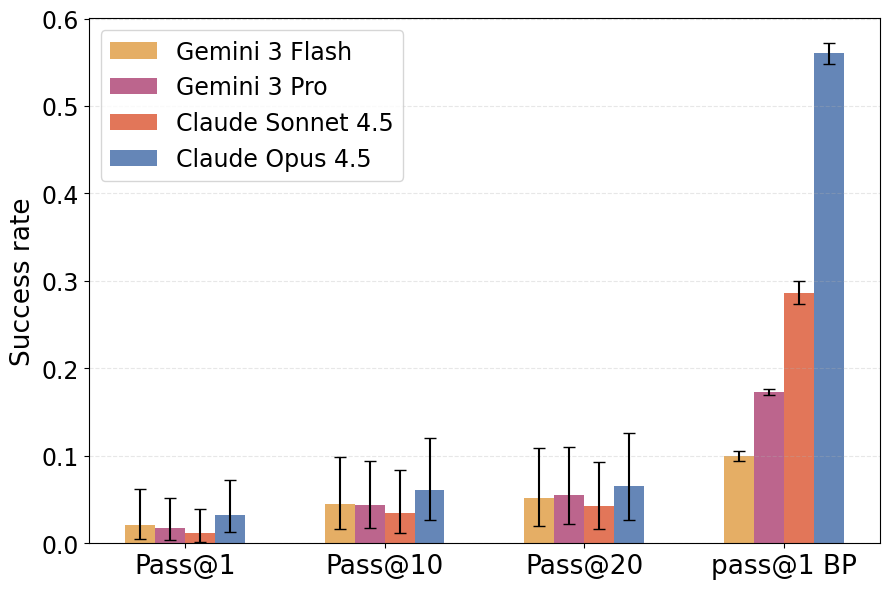

In [ ]:
n_configs = len(pass_at_k_configs)
n_bars = n_configs
bar_width = 0.15
x = np.arange(len(k_values) + 1)  # +1 for the "full" system

plt.figure(figsize=FIGSIZE)
for i, config in enumerate(pass_at_k_configs):
    means = []
    yerr_low = []
    yerr_high = []

    # Collect pass@k values for this config
    for k in k_values:
        val, ci = pass_at_k_by_config[config][k]
        means.append(val)
        yerr_low.append(max(0, val - ci.low))
        yerr_high.append(max(0, ci.high - val))

    # Add full system performance
    mean_val, sem = pass_at_k_by_config[config]["full"]
    means.append(mean_val)
    yerr_low.append(sem)
    yerr_high.append(sem)

    # Center the group of bars around the tick
    offset = (i - (n_bars - 1) / 2) * bar_width
    plt.bar(
        x + offset,
        means,
        bar_width,
        label=CONFIG_NAME_MAP[config],
        color=get_color(config)["medium"],
        yerr=[yerr_low, yerr_high],
        capsize=4,
    )

x_labels = [f"Pass@{k}" for k in k_values] + [f"pass@1 {PROVER_ACRONYM}"]
plt.xticks(x, x_labels, fontsize=FONTSIZE)
plt.yticks(fontsize=LABELSIZE)
plt.ylabel("Success rate", fontsize=FONTSIZE)
plt.legend(fontsize=LABELSIZE)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("data/figures/llm_comparison.pdf", bbox_inches="tight")

# Cost analysis

Here we look at the performance vs cost of the models, and provide some ablations on the thinking parameters.

In [ ]:
from dataclasses import dataclass


@dataclass
class CostPerformanceSummary:
    success_rate: float
    total_cost: float


def fetch_cost_performance_summary(experiment_name: str, client: Client):
    "Get the average success rate and total cost of an experiment."
    experiment_summary = client.read_project(project_name=experiment_name, include_stats=True)
    cost_performance = CostPerformanceSummary(
        experiment_summary.feedback_stats["is_proven"]["avg"], float(experiment_summary.total_cost)
    )
    return cost_performance


def fetch_cost_performance_data(ablation: Ablation, client: Client):
    """Retrieve the data for all the experiments in a given ablation study."""
    experiments_dataset = get_experiment_names_by_dataset(client, ablation.dataset_name)
    for config in tqdm(ablation.config_names):
        experiment_names = filter_experiment_names_by_config(config, experiments_dataset)
        for experiment_name in experiment_names:
            cost_performance = fetch_cost_performance_summary(experiment_name, client)
            if "flash" in experiment_name:
                cost_performance.total_cost = compute_flash_experiment_cost(experiment_name, client)
            ablation.data[config].append(cost_performance)

    return ablation


def calculate_flash_cost(input_tokens: int, output_tokens: int):
    # model_name = "gemini-3-flash-preview"
    input_price_per_1m = 0.50
    output_price_per_1m = 3.00

    input_cost = (input_tokens / 1_000_000) * input_price_per_1m
    output_cost = (output_tokens / 1_000_000) * output_price_per_1m
    return input_cost + output_cost


def compute_flash_experiment_cost(experiment_name: str, client: Client):
    runs = client.list_runs(project_name=experiment_name, is_root=True)

    total_cost = 0.0
    for run in runs:
        run_cost = calculate_flash_cost(run.input_tokens, run.output_tokens)
        total_cost += run_cost

    return total_cost

In [ ]:
CONFIG_NAME_MAP = {
    "sonnetlow": "Claude Sonnet\n(2k)",
    "sonnet": "Claude Sonnet\n(10k)",
    "sonnethigh": "Claude Sonnet\n(32k)",
    "opuslow": "Claude Opus\n(2k)",
    "fullsystem": "Claude Opus\n(10k - 100 it)",
    "opushigh": "Claude Opus\n(32k)",
    "flashminimal": "Gemini Flash\n(minimal)",
    "flashlow": "Gemini Flash\n(low)",
    "flash": "Gemini Flash\n(high)",
    "prolow": "Gemini Pro\n(low)",
    "pro": "Gemini Pro\n(high)",
}

In [ ]:
# client = Client()
# dataset_name = "putnam_medium_solutions"
# cost_performance = Ablation("cost_performance", dataset_name, list(CONFIG_NAME_MAP.keys()))
# cost_performance = fetch_cost_performance_data(cost_performance, client)

In [ ]:
import pickle

# with open("data/cost_performance.pkl", "wb") as f:
#     pickle.dump(cost_performance, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("data/cost_performance.pkl", "rb") as f:
    cost_performance = pickle.load(f)

Let's compute the average performance and cost for each ablation, and normalize all the costs by the highest one.

In [ ]:
cost_perf_by_config = {}

max_cost = 0
for config in cost_performance.config_names:
    results = pd.DataFrame(cost_performance.data[config])

    mean_perf, mean_cost = results.success_rate.mean(axis=0), results.total_cost.mean(axis=0)

    if mean_cost > max_cost:
        max_cost = mean_cost

    if results.shape[0] > 1:
        sem_perf, sem_cost = results.success_rate.sem(axis=0), results.total_cost.sem(axis=0)
    else:
        sem_perf, sem_cost = 0, 0

    cost_perf_by_config[config] = (mean_cost, sem_cost, mean_perf, sem_perf)

We have the full system at 100 iterations, but we need to estimate its cost and performance at 50 iterations.
We will repeat what we've done for the preivous plot to compare at 50 iteartions, as well as count the amount of iterationst o estimate the cost.

In [ ]:
opus_config = "fullsystem"
proven_matrix = aggregate_results_by_run(
    long_run.data[opus_config],
    ["feedback.is_proven", "feedback.main_theorem_iterations"],
    ["input.inputs.path"],
)

under_50_iterations = proven_matrix["feedback.main_theorem_iterations"] <= 50
proven_within_50 = proven_matrix["feedback.is_proven"].astype(bool) & under_50_iterations
success_rate_per_run = proven_within_50.mean(axis=0)
mean_perf, sem_perf = success_rate_per_run.mean(), success_rate_per_run.sem()

iterations = proven_matrix["feedback.main_theorem_iterations"]
total_iterations = iterations.sum().sum()
iterations_under_50 = iterations.where(under_50_iterations, 50).sum().sum()
cost_fraction = iterations_under_50 / total_iterations
mean_cost = cost_perf_by_config["fullsystem"][0] * cost_fraction
sem_cost = cost_perf_by_config["fullsystem"][1]

cost_perf_by_config["fullshort"] = (mean_cost, sem_cost, mean_perf, sem_perf)

CONFIG_NAME_MAP["fullshort"] = "Claude Opus\n(10k)"

In [ ]:
import matplotlib.pyplot as plt

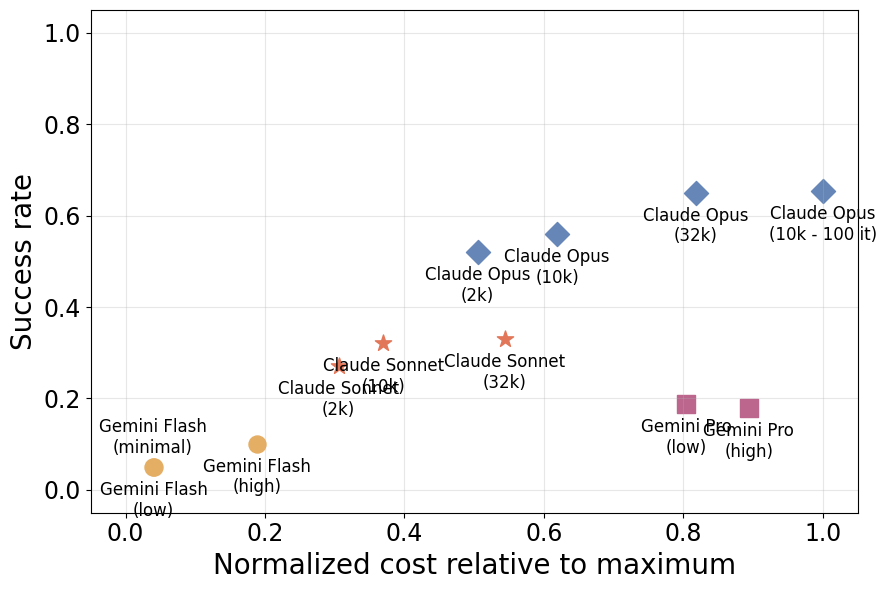

In [ ]:
def assign_marker(label: str):
    if "flash" in label:
        return "o"
    if "pro" in label:
        return "s"
    if "opus" in label or "full" in label:
        return "D"
    if "sonnet" in label:
        return "*"
    return "o"


# Cost vs performance scatter (cost normalized by max_cost)
plt.figure(figsize=FIGSIZE)
for config in cost_perf_by_config.keys():
    mean_cost, sem_cost, mean_perf, sem_perf = cost_perf_by_config[config]
    x = (mean_cost / max_cost) if max_cost else 0.0
    y = float(mean_perf)
    label = CONFIG_NAME_MAP.get(config, config)

    plt.scatter(x, y, s=150, marker=assign_marker(config), color=get_color(config)["medium"])
    xy_text = (0, 35) if "minimal" in config else (0, -10)
    plt.annotate(
        label,
        (x, y),
        xytext=xy_text,
        textcoords="offset points",
        ha="center",
        va="top",
        fontsize=TEXTSIZE,
    )

plt.xlabel("Normalized cost relative to maximum", fontsize=FONTSIZE)
plt.ylabel("Success rate", fontsize=FONTSIZE)
plt.tick_params(labelsize=LABELSIZE)
plt.grid(alpha=0.3)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
# plt.savefig("data/figures/cost_performance.pdf", bbox_inches="tight")

# Analyze benchmarks

## Putnam Bench
We split the dataset into 6 parts of 110 problems each to prove it faster in parallel.
Thus, we need to load all of the splits and combine them.

In [ ]:
client = Client()
dataset_names = [f"putnam_solutions_part{i}_of_6" for i in range(1, 7)]
CONFIG_NAME = "opushigh"
CHEATED_ON = 4

In [ ]:
results = []
for dataset_name in tqdm(dataset_names):
    experiments_dataset = get_experiment_names_by_dataset(client, dataset_name)
    experiment_names = filter_experiment_names_by_config(CONFIG_NAME, experiments_dataset)
    if len(experiment_names) > 1:
        raise ValueError(
            f"Expected 1 experiment name, got {len(experiment_names)} for {dataset_name}"
        )
    results.append(client.get_test_results(project_name=experiment_names[0]))

Now let's just concatenate all the data and get the numbers!

In [ ]:
full_data = pd.concat(results, ignore_index=True)
print(f"Total of {len(full_data)} samples")

Total of 660 samples


There were some problems where we had `apply?` in the proof, so we can't count them.

In [ ]:
proven_samples = full_data["feedback.is_proven"].sum()
print(
    f"Total of {proven_samples - CHEATED_ON:.0f} ({(proven_samples - CHEATED_ON) / len(full_data):.2%}) proven samples"
)

Total of 361 (54.70%) proven samples


## FATE M

In [ ]:
client = Client()
EXPERIMENT_NAME = "ax-0127162132-fatem-opushigh-d8d28b15"

In [ ]:
results = client.get_test_results(project_name=EXPERIMENT_NAME)

In [ ]:
proven_samples = results["feedback.is_proven"].sum()
print(f"Total of {proven_samples:.0f} ({(proven_samples) / len(results):.2%}) proven samples")

Total of 147 (98.00%) proven samples


## FATE H

In [ ]:
client = Client()
EXPERIMENT_NAME = "ax-0126152116-fateh-opushigh-53fd7ba2"

In [ ]:
results = client.get_test_results(project_name=EXPERIMENT_NAME)

/var/folders/gk/ksd5gm5559xgbgc8z5v6z4zw0000gn/T/ipykernel_23026/3017169904.py:1: UserWarning: Function get_test_results is in beta.
  results = client.get_test_results(project_name=EXPERIMENT_NAME)


In [ ]:
proven_samples = results["feedback.is_proven"].sum()
print(f"Total of {proven_samples:.0f} ({(proven_samples) / len(results):.2%}) proven samples")

Total of 66 (66.00%) proven samples


## FATE X

In [ ]:
client = Client()
EXPERIMENT_NAME = "ax-0127162201-fatex-opushigh-fc722928"
CHEATED_ON = 14  # Used `apply?` at some point in the proof

In [ ]:
results = client.get_test_results(project_name=EXPERIMENT_NAME)

In [ ]:
proven_samples = results["feedback.is_proven"].sum() - CHEATED_ON
print(f"Total of {proven_samples:.0f} ({(proven_samples) / len(results):.2%}) proven samples")

Total of 24 (24.00%) proven samples


## LeanCAT

In [ ]:
client = Client()
EXPERIMENT_NAME = "ax-0126195556-leancat-opushigh-6eb4f571"

In [ ]:
results = client.get_test_results(project_name=EXPERIMENT_NAME)

In [ ]:
proven_samples = results["feedback.is_proven"].sum()
print(f"Total of {proven_samples:.0f} ({(proven_samples) / len(results):.2%}) proven samples")

Total of 59 (59.00%) proven samples
